# 1. Construyo portafolio


## 1.1 Calculo ponderaciones

Entreno modelo usando 2 meses de cotizacion utilizando los cedears disponibles que existen en Argentina que tengan liquidez.

In [1]:
import json
import numpy as np
import pandas as pd
import yfinance as yf
import requests

from datetime import date, timedelta
from dateutil.relativedelta import relativedelta
from empyrial import empyrial, Engine, get_report
from scipy.optimize import nnls


In [2]:
yesterday = date.today() + timedelta(days=-1)

train_start = (yesterday - relativedelta(months=5)).isoformat()
train_end = yesterday.isoformat()

In [7]:
#available_cedears_list = ['AAPL', 'ABBV', 'AMD', 'ADBE', 'AMZN', 'BA', 'BAC', 'BB', 'BRK-B', 'C', 'CAT', 'CVX', 'COST', 'DIS', 'EBAY', 'FB', 'GE', 'GOLD', 'GOOGL', 'GS', 'INTC', 'JNJ', 'JPM', 'KO', 'MCD', 'MMM', 'MRK', 'MSFT', 'NFLX', 'NVDA', 'PFE', 'PEP', 'PG', 'PYPL', 'QCOM', 'SBUX','SONY', 'SPOT', 'TRIP', 'TSLA', 'TWTR', 'UGP', 'V', 'VZ', 'WFC', 'WMT', 'X', 'XOM']
available_cedears_list = ['AAPL', 'ABBV', 'AMD', 'ADBE', 'AMZN', 'BA', 'BAC', 'BRK-B', 'C', 'CAT', 'CVX', 'COST', 'DIS', 'EBAY', 'FB', 'GE', 'GOLD', 'GOOGL', 'GS', 'INTC', 'JNJ', 'JPM', 'KO', 'MCD', 'MMM', 'MRK', 'MSFT', 'NFLX', 'NVDA', 'PFE', 'PEP', 'PG', 'PYPL', 'QCOM', 'SBUX','SONY', 'SPOT', 'TRIP', 'TSLA', 'TWTR', 'UGP', 'V', 'VZ', 'WFC', 'WMT', 'X', 'XOM']

In [8]:
components = yf.download(
              tickers=available_cedears_list,
              start=train_start,
              end=train_end,
              interval="1d",
              group_by="column",
              auto_adjust=True,
              prepost=False,
              threads=True
            )['Close']

df = components.copy()
df.dropna(inplace=True)

df['Actual Close'] = yf.download(
                tickers="SSO", # SP500 ETF X2
                start=train_start,
                end=train_end,
                interval="1d",
                group_by="column",
                auto_adjust=True,
                prepost=False,
                threads=True
              )['Close']

[*********************100%***********************]  47 of 47 completed
[*********************100%***********************]  1 of 1 completed


In [9]:
trainX = df.drop('Actual Close', axis=1)
trainY = df['Actual Close']

NNLS Residual 11.82332

Portfolio Allocation:


,Component,Weight(%)
0,X,24.936420
1,BAC,19.746240
2,AAPL,14.469236
3,QCOM,9.281753
4,SPOT,7.445062
5,MSFT,5.498348
6,EBAY,3.638487
7,GS,3.565339
8,AMD,2.762656
9,WFC,2.729421



Portfolio Simulated Close = 
1.119(0.14469*AAPL + 0.01618*ABBV + 0.0*ADBE + 0.02763*AMD + 0.0*AMZN + 0.0*BA + 0.19746*BAC + 0.0*BRK-B + 0.0*C + 0.01678*CAT + 0.0*COST + 0.0*CVX + 0.0*DIS + 0.03638*EBAY + 0.0*FB + 0.0*GE + 0.0*GOLD + 0.0*GOOGL + 0.03565*GS + 0.0*INTC + 0.0*JNJ + 0.0*JPM + 0.0*KO + 0.0*MCD + 0.0*MMM + 0.0*MRK + 0.05498*MSFT + 0.0*NFLX + 0.00585*NVDA + 0.0*PEP + 0.0*PFE + 0.0*PG + 0.0*PYPL + 0.09282*QCOM + 0.0*SBUX + 0.0*SONY + 0.07445*SPOT + 0.0*TRIP + 0.0*TSLA + 0.0*TWTR + 0.0*UGP + 0.02047*V + 0.0*VZ + 0.02729*WFC + 0.0*WMT + 0.24936*X + 0.0*XOM)

Leverage Factor: 1.1190000688862611


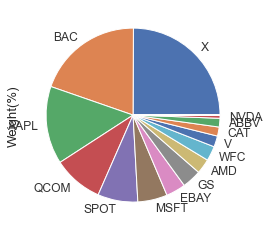

In [10]:
# Obtain coeffs from NNLS training
def get_portfolio_allocation(trainX, trainY):
    result = nnls(trainX, trainY, maxiter=10000)
    print('NNLS Residual', round(result[1],5))

    leverage_factor = sum(result[0])
    weights = result[0] / leverage_factor
    weights = dict(zip(trainX.columns, weights))

    s1 = str(round(leverage_factor,5))+"("
    for component in weights.keys():
        s1 += str(round(weights[component],5))+'*'+component+" + "
    s1 = s1[:-3]+")"

    print("\nPortfolio Allocation:")
    allocation = pd.DataFrame({'Component':list(weights.keys()),'Weight(%)':np.multiply(list(weights.values()),100)}).sort_values('Weight(%)',ascending=False)
    allocation.set_index('Component',inplace=True)
    allocation.plot.pie(y='Weight(%)',legend=None)
    allocation.reset_index(inplace=True)
    display(allocation)

    print('\nPortfolio Simulated Close = ')
    print(s1)
    print("\nLeverage Factor:", leverage_factor)
    return leverage_factor, weights

leverage_factor, weights = get_portfolio_allocation(trainX, trainY)

## 1.2 Evalúo performance de portafolio teórico

In [11]:
weights = {x:y for x,y in weights.items() if y!=0}

Start date: 2021-07-27
End date: 2021-12-28


,Backtest
,
Annual return,37.74%
Cumulative return,14.42%
Annual volatility,20.2 %
Winning day ratio,57.55%
Sharpe ratio,1.69
Calmar ratio,3.89
Information ratio,0.0
Stability,0.36
Max Drawdown,-9.82 %


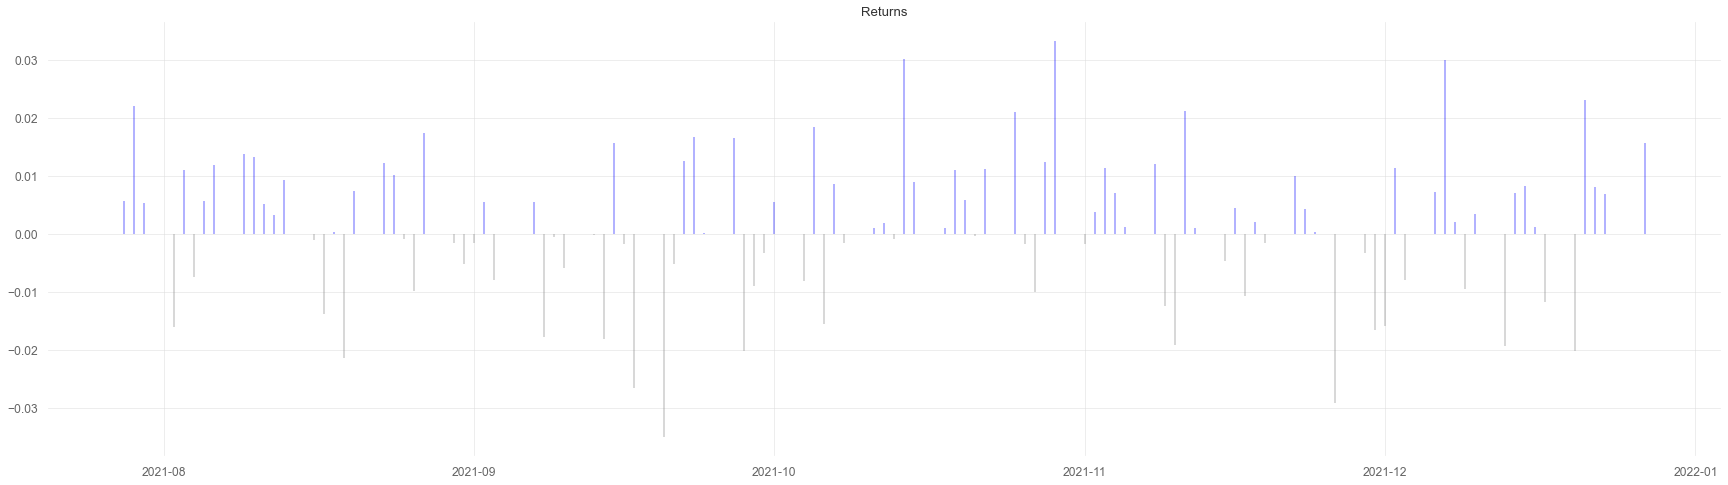

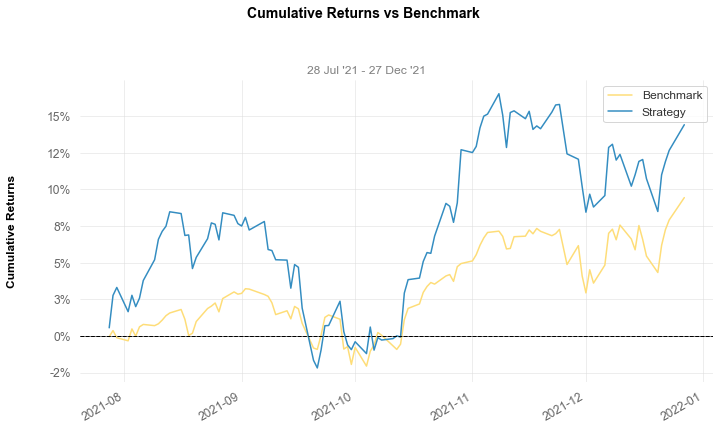

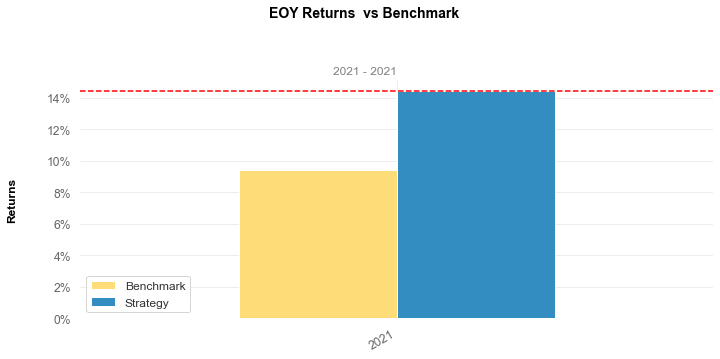

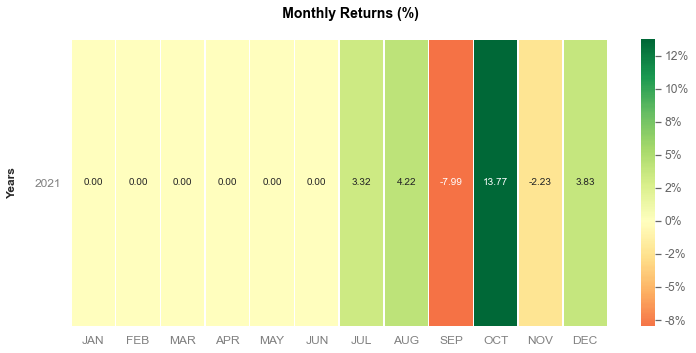

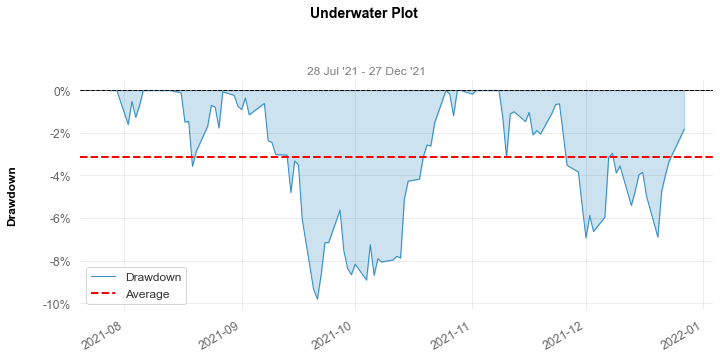

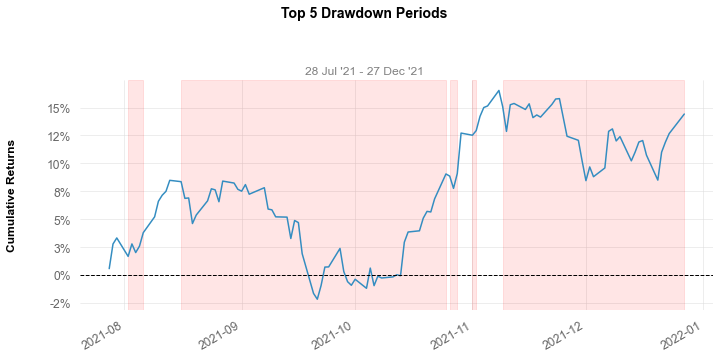

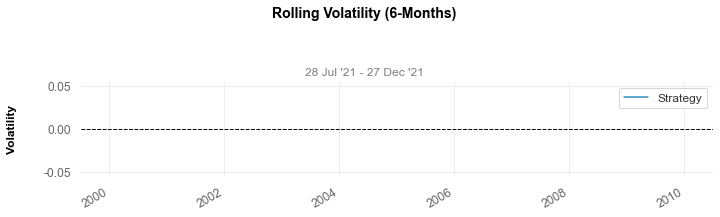

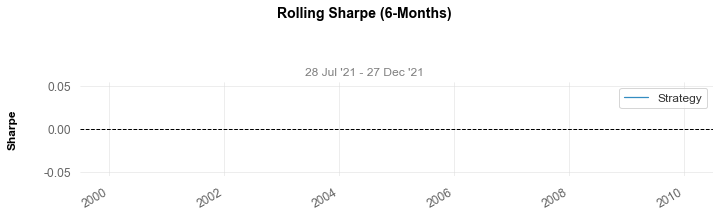

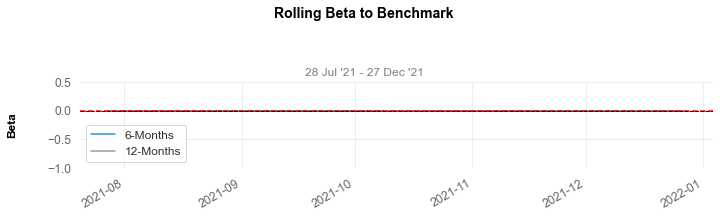

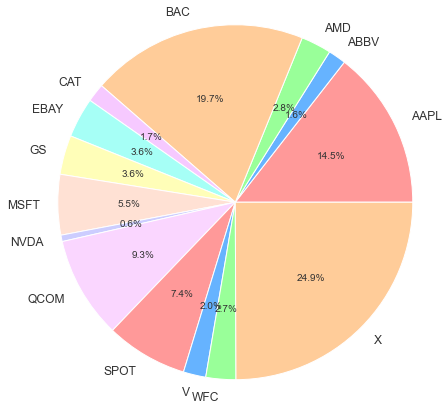

In [12]:

portfolio = Engine(
  start_date=train_start,
  portfolio=list(weights.keys()),
  weights=list(weights.values()),
  benchmark = ["SPY"]
)

data = empyrial(portfolio)

In [83]:
data

(None, None, None, None, None, None, None, None, None)

In [10]:
get_report(portfolio)

## 1.3 Escribo el resultado a archivo json

In [11]:
# Corrijo los nombres para poder operar sus cedears
weights['BA.C'] = weights.pop('BAC')
weights['BRKB'] = weights.pop('BRK-B')
weights['DISN'] = weights.pop('DIS')

KeyError: 'BAC'

In [12]:
portfolio_json = {x:y for x,y in weights.items() if y!=0} # removes 0 weighted stocks
portfolio_json

{'AAPL': 0.28497897299425207,
 'BA': 0.01810107648251659,
 'CAT': 0.009114102365703154,
 'FB': 0.023574665418561427,
 'GE': 0.0330365146427014,
 'GOOGL': 0.008457570598978515,
 'GS': 0.02634803885321254,
 'MSFT': 0.0007168397658897361,
 'NVDA': 0.0888919223192844,
 'SBUX': 0.1272315443871363,
 'WFC': 0.0869068168324687,
 'X': 0.29264193533929517}

In [13]:
with open('portfolio.json', 'w') as fp:
    json.dump(portfolio_json, fp)

In [25]:
!pip install python-telegram-bot --upgrade


     |████████████████████████████████| 490 kB 1.3 MB/s 
     |████████████████████████████████| 58 kB 9.9 MB/s 


In [14]:
import telegram

In [15]:
bot = telegram.Bot(token='1927796162:AAFvXT4ZJPt1NwldQKk9S8MU5CwL4Z2v5Vw')

In [28]:
print(bot.get_me())

{'can_join_groups': True, 'is_bot': True, 'id': 1927796162, 'username': 'Alfy500Bot', 'can_read_all_group_messages': False, 'first_name': 'Alfy500', 'supports_inline_queries': False}


In [95]:
updates = bot.get_updates()

In [96]:
print(updates[-1])

{'message': {'caption_entities': [], 'photo': [], 'new_chat_members': [], 'text': '/start', 'chat': {'id': 534374206, 'type': 'private', 'first_name': 'Noelia', 'last_name': 'Silva'}, 'date': 1629935691, 'message_id': 23, 'supergroup_chat_created': False, 'group_chat_created': False, 'entities': [{'offset': 0, 'length': 6, 'type': 'bot_command'}], 'channel_chat_created': False, 'delete_chat_photo': False, 'new_chat_photo': [], 'from': {'language_code': 'es', 'last_name': 'Silva', 'is_bot': False, 'id': 534374206, 'first_name': 'Noelia'}}, 'update_id': 270130448}


In [97]:
bot.send_message(text='Hello World!', chat_id=534374206)

In [16]:
message1 = '🤖 ALFY500 BOT - Conseguí retornos apalancados del S&P500 con tus cedears!'
message2 = '💼 Portafolio sugerido para este mes:\n\n'
for key in {k: v for k, v in sorted(portfolio_json.items(), key=lambda item: item[1], reverse=True)}:
  message2 += '☑️ ' + key + ': ' + str(round(portfolio_json[key] * 10000) / 100) + '%\n'

In [17]:
message2

'💼 Portafolio sugerido para este mes:\n\n☑️ X: 29.26%\n☑️ AAPL: 28.5%\n☑️ SBUX: 12.72%\n☑️ NVDA: 8.89%\n☑️ WFC: 8.69%\n☑️ GE: 3.3%\n☑️ GS: 2.63%\n☑️ FB: 2.36%\n☑️ BA: 1.81%\n☑️ CAT: 0.91%\n☑️ GOOGL: 0.85%\n☑️ MSFT: 0.07%\n'

In [18]:
bot.send_message(text=message1, chat_id=534374206)
bot.send_message(text=message2, chat_id=534374206)
bot.send_photo(chat_id=534374206, photo=open('retbench.png', 'rb'), caption='📈 Así rindió este portafolio comparado con el S&P500 en los últimos 2 meses')
bot.send_document(chat_id=534374206, document=open('report.pdf', 'rb'), caption='🤓 Reporte con datos técnicos y métricas de riesgo')